# 範例 : (Kaggle)房價預測
***
- 以下用房價預測資料, 觀察降低資料偏態的影響

# [教學目標]
- 以下用房價預測資料, 觀察降低偏態的影響

# [範例重點]
- 觀察原始數值的散佈圖, 以及線性迴歸分數 (Out[4], Out[5]) 
- 觀察使用log1p降偏態時, 對於分布與迴歸分數的影響 (In[6], Out[6])
- 觀察使用box-cox(λ=0.15)時, 對於分布與迴歸分數的影響 (In[7], Out[7])
- 觀察使用sqrt(box-cox, λ=0.5)時, 對於分布與迴歸分數的影響 (In[8], Out[8])

In [2]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = './homework/data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')
df_test = pd.read_csv(data_path + 'house_test.csv.gz')

train_Y = np.log1p(df_train['SalePrice'])
ids = df_test['Id']
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

pd.set_option('display.max_columns', None)

In [3]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008


In [5]:
 train_num

1460

In [9]:
df['LotArea'][:]

0        8450
1        9600
2       11250
3        9550
4       14260
5       14115
6       10084
7       10382
8        6120
9        7420
10      11200
11      11924
12      12968
13      10652
14      10920
15       6120
16      11241
17      10791
18      13695
19       7560
20      14215
21       7449
22       9742
23       4224
24       8246
25      14230
26       7200
27      11478
28      16321
29       6324
        ...  
1429     7030
1430     9060
1431    12366
1432     9000
1433     8520
1434     5748
1435     3842
1436    23580
1437     8385
1438     9116
1439    11080
1440    50102
1441     8098
1442    13618
1443    11577
1444    31250
1445     7020
1446     2665
1447    10172
1448    11836
1449     1470
1450     1484
1451    13384
1452     1533
1453     1526
1454     1936
1455     1894
1456    20000
1457    10441
1458     9627
Name: LotArea, Length: 2919, dtype: int64

In [6]:
df['LotArea'][:train_num]

0        8450
1        9600
2       11250
3        9550
4       14260
5       14115
6       10084
7       10382
8        6120
9        7420
10      11200
11      11924
12      12968
13      10652
14      10920
15       6120
16      11241
17      10791
18      13695
19       7560
20      14215
21       7449
22       9742
23       4224
24       8246
25      14230
26       7200
27      11478
28      16321
29       6324
        ...  
1430    21930
1431     4928
1432    10800
1433    10261
1434    17400
1435     8400
1436     9000
1437    12444
1438     7407
1439    11584
1440    11526
1441     4426
1442    11003
1443     8854
1444     8500
1445     8400
1446    26142
1447    10000
1448    11767
1449     1533
1450     9000
1451     9262
1452     3675
1453    17217
1454     7500
1455     7917
1456    13175
1457     9042
1458     9717
1459     9937
Name: LotArea, Length: 1460, dtype: int64

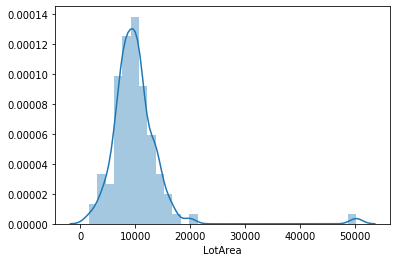

In [13]:
# 顯示 LotArea 的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df['LotArea'][:100])


In [14]:
# 計算基礎分數
df_mm = MMEncoder.fit_transform(df)

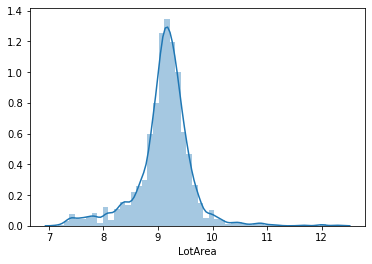

0.852911262961794


In [15]:
# 將 LotArea 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
df_fixed['LotArea'] = np.log1p(df_fixed['LotArea'])
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

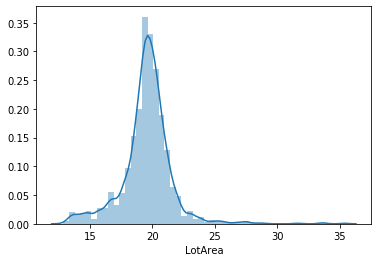

0.852064259070573


In [16]:
# 將 LotArea 取 boxcox 後, 看散佈圖, 並計算分數
from scipy import stats
df_fixed = copy.deepcopy(df)
df_fixed['LotArea'] = stats.boxcox(df_fixed['LotArea'], lmbda=0.15)
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

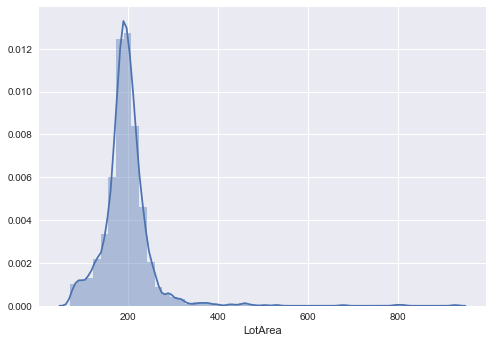

0.8490937061232051


In [7]:
# 將 LotArea 取 sqrt (box-cox : alpha=0.5) 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
df_fixed['LotArea'] = stats.boxcox(df['LotArea'], lmbda=0.5)
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

# 作業1 
* 試著在鐵達尼的票價 (Fare) 欄位中使用對數去偏 (log1p) , 結果是否更好?

# 作業2
* 最後的 boxcox 區塊直接執行會造成錯誤, 起因為輸入值有負值, 請問如何修正後可以使用 boxcox?(Hint : 試圖修正資料)